<script async src="https://www.googletagmanager.com/gtag/js?id=UA-59152712-8"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-59152712-8');
</script>

# Start-to-Finish Example: Studying Gravitational Wave Ringdown from Head-On Black Hole Collision

## Author: Zach Etienne
### Formatting improvements courtesy Brandon Clark

## This module implements a basic numerical relativity code to merge two black holes in *spherical-like coordinates*, as well as the gravitational wave analysis provided by the $\psi_4$ NRPy+ tutorial notebooks ([$\psi_4$](Tutorial-Psi4.ipynb) & [$\psi_4$ tetrad](Tutorial-Psi4_tetrads.ipynb)).

### Here we place the black holes initially on the $z$-axis, so the entire simulation is axisymmetric about the $\phi$-axis. Minimal sampling in the $\phi$ direction greatly speeds up the simulation.

**Notebook Status:** <font color = green><b> Validated </b></font>

**Validation Notes:** This module has been validated to exhibit convergence to zero of the Hamiltonian constraint violation at the expected order to the exact solution *after a short numerical evolution of the initial data* (see [plots at bottom](#convergence)), and all quantities have been validated against the [original SENR code](https://bitbucket.org/zach_etienne/nrpy). Finally, excellent agreement is seen in the gravitational wave signal from the ringing remnant black hole for multiple decades in amplitude when compared to black hole perturbation theory predictions of the exponential dropoff and frequency.

### NRPy+ Source Code & Tutorials for this module: 
* [BSSN/BrillLindquist.py](../edit/BSSN/BrillLindquist.py); [\[**tutorial**\]](Tutorial-ADM_Initial_Data-Brill-Lindquist.ipynb): Brill-Lindquist initial data; sets all ADM variables in Cartesian basis: 
* [BSSN/ADM_Initial_Data_Reader__BSSN_Converter.py](../edit/BSSN/ADM_Initial_Data_Reader__BSSN_Converter.py); [\[**tutorial**\]](Tutorial-ADM_Initial_Data_Reader__BSSN_Converter.ipynb): Registers the C function for our "universal" initial data reader/converter initial_data_reader__convert_ADM_Cartesian_to_BSSN().
* [CurviBoundaryConditions/CurviBoundaryConditions.py](../edit/CurviBoundaryConditions/CurviBoundaryConditions.py); [\[**tutorial**\]](Tutorial-Start_to_Finish-Curvilinear_BCs.ipynb): Registers the C function for our "universal" initial data reader/converter initial_data_reader__convert_ADM_Cartesian_to_BSSN(). This applies boundary conditions to BSSN quantities (including $\lambda^i$, which is computed via finite difference derivatives and thus only defined in grid interior)
* [BSSN/BSSN_Ccodegen_library.py](../edit/BSSN/BSSN_Ccodegen_library.py); [\[**tutorial**\]](Tutorial-BSSN_time_evolution-C_codegen_library.ipynb): Implements a number of helper functions for generating C codes from symbolic expressions generated in the following modules/tutorials:
    * [BSSN/BSSN_constraints.py](../edit/BSSN/BSSN_constraints.py); [\[**tutorial**\]](Tutorial-BSSN_constraints.ipynb): Hamiltonian constraint in BSSN curvilinear basis/coordinates
    * [BSSN/BSSN_RHSs.py](../edit/BSSN/BSSN_RHSs.py); [\[**tutorial**\]](Tutorial-BSSN_time_evolution-BSSN_RHSs.ipynb): Generates the right-hand sides for the BSSN evolution equations in singular, curvilinear coordinates
    * [BSSN/BSSN_gauge_RHSs.py](../edit/BSSN/BSSN_gauge_RHSs.py); [\[**tutorial**\]](Tutorial-BSSN_time_evolution-BSSN_gauge_RHSs.ipynb): Generates the right-hand sides for the BSSN gauge evolution equations in singular, curvilinear coordinates
    * [BSSN/Psi4.py](../edit/BSSN/Psi4.py); [\[**tutorial**\]](Tutorial-Psi4.ipynb): Generates expressions for $\psi_4$, the outgoing Weyl scalar
        + [BSSN/Psi4_tetrads.py](../edit/BSSN/Psi4_tetrads.py); [\[**tutorial**\]](Tutorial-Psi4_tetrads.ipynb): Generates quasi-Kinnersley tetrad needed for $\psi_4$-based gravitational wave extraction


## Introduction:
Here we use NRPy+ to generate the C source code necessary to set up initial data for two black holes (Brill-Lindquist, [Brill & Lindquist, Phys. Rev. 131, 471, 1963](https://journals.aps.org/pr/abstract/10.1103/PhysRev.131.471); see also Eq. 1 of [Brandt & Brügmann, arXiv:gr-qc/9711015v1](https://arxiv.org/pdf/gr-qc/9711015v1.pdf)). Then we use it to generate the RHS expressions for [Method of Lines](https://reference.wolfram.com/language/tutorial/NDSolveMethodOfLines.html) time integration based on an [explicit Runge-Kutta fourth-order scheme](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) (RK4 is chosen below, but multiple options exist). 

The entire algorithm is outlined as follows, with links to the relevant NRPy+ tutorial notebooks listed at each step:

1. Allocate memory for gridfunctions, including temporary storage for the Method of Lines time integration
    * [**NRPy+ tutorial on Method of Lines algorithm**](Tutorial-Method_of_Lines-C_Code_Generation.ipynb).
1. Set gridfunction values to initial data 
    * [**NRPy+ tutorial on Brill-Lindquist initial data**](Tutorial-ADM_Initial_Data-Brill-Lindquist.ipynb)
    * [**NRPy+ tutorial on validating Brill-Lindquist initial data**](Tutorial-Start_to_Finish-BSSNCurvilinear-Exact_Initial_Data.ipynb).
1. Next, integrate the initial data forward in time using the Method of Lines coupled to a Runge-Kutta explicit timestepping algorithm:
    1. At the start of each iteration in time, output the Hamiltonian constraint violation 
        * [**NRPy+ tutorial on BSSN constraints**](Tutorial-BSSN_constraints.ipynb).
    1. At each RK time substep, do the following:
        1. Evaluate BSSN RHS expressions 
            * [**NRPy+ tutorial on BSSN right-hand sides**](Tutorial-BSSN_time_evolution-BSSN_RHSs.ipynb) ([**BSSN Introduction Notebook**](Tutorial-BSSN_formulation.ipynb))
            * [**NRPy+ tutorial on BSSN gauge condition right-hand sides**](Tutorial-BSSN_time_evolution-BSSN_gauge_RHSs.ipynb) 
        1. Apply singular, curvilinear coordinate boundary conditions [*a la* the SENR/NRPy+ paper](https://arxiv.org/abs/1712.07658)
            * [**NRPy+ tutorial on setting up singular, curvilinear boundary conditions**](Tutorial-Start_to_Finish-Curvilinear_BCs.ipynb)
        1. Enforce constraint on conformal 3-metric: $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ 
            * [**NRPy+ tutorial on enforcing $\det{\bar{\gamma}_{ij}}=\det{\hat{\gamma}_{ij}}$ constraint**](Tutorial-BSSN_enforcing_determinant_gammabar_equals_gammahat_constraint.ipynb)
1. Repeat above steps at two numerical resolutions to confirm convergence to zero.

<a id='toc'></a>

# Table of Contents
$$\label{toc}$$

This notebook is organized as follows

1. [Step 1](#initializenrpy): Set core NRPy+ parameters for numerical grids and reference metric
1. [Step 2](#ccodegen): Generate C code kernels for BSSN expressions, in parallel if possible
    1. [Step 2.a](#rfm_ccodegen): Generate C code kernels for reference metric
1. [Step 3](#cparams_rfm_and_domainsize): Set `free_parameters.h`; also output C codes needed for declaring and setting Cparameters
1. [Step 4](#bc_functs): Set up boundary condition functions for chosen singular, curvilinear coordinate system
1. [Step 5](#mainc): `BrillLindquist_Playground`: The C code `main()` function
1. [Step 6](#compileexec): Compile generated C codes & perform the black hole collision calculation
1. [Step 7](#visualize): Visualize the output!
    1. [Step 7.a](#installdownload): Install `scipy` and download `ffmpeg` if they are not yet installed/downloaded
    1. [Step 7.b](#genimages): Generate images for visualization animation
    1. [Step 7.c](#genvideo): Generate visualization animation
1. [Step 8](#numerror): Plot the numerical error at the end of the simulation
1. [Step 9](#compare): Compare ringdown gravitational wave signal with black hole perturbation theory
1. [Step 10](#latex_pdf_output): Output this notebook to $\LaTeX$-formatted PDF file

<a id='initializenrpy'></a>

# Step 1: Set core NRPy+ parameters for numerical grids and reference metric \[Back to [top](#toc)\]
$$\label{initializenrpy}$$

In [1]:
# Step P1: Import needed NRPy+ core modules:
from outputC import add_to_Cfunction_dict, outC_function_master_list # NRPy+: Core C code output module
import finite_difference as fin  # NRPy+: Finite difference C code generation module
import NRPy_param_funcs as par   # NRPy+: Parameter interface
import grid as gri               # NRPy+: Functions having to do with numerical grids
import reference_metric as rfm   # NRPy+: Reference metric support
import cmdline_helper as cmd     # NRPy+: Multi-platform Python command-line interface
from pickling import unpickle_NRPy_env  # NRPy+: Pickle/unpickle NRPy+ environment, for parallel codegen
import shutil, os, sys           # Standard Python modules for multiplatform OS-level functions, benchmarking

EvolOption = "low resolution"

if EvolOption == "low resolution":
    FD_order  = 8  # Finite difference order: even numbers only, starting with 2. 12 is generally unstable
    # domain_size sets the default value for:
    #   * Spherical's params.RMAX
    #   * SinhSpherical*'s params.AMAX
    #   * Cartesians*'s -params.{x,y,z}min & .{x,y,z}max
    #   * Cylindrical's -params.ZMIN & .{Z,RHO}MAX
    #   * SinhCylindrical's params.AMPL{RHO,Z}
    #   * *SymTP's params.AMAX
    domain_size = 150
    Nr          = 270
    Nth         = 8
    Nph         = 2
    CFL_FACTOR  = 1.0  # In pure axisymmetry (symmetry_axes = 2 below) 1.0 works fine. Otherwise 0.5 or lower.
elif EvolOption == "high resolution":
    FD_order  = 10  # Finite difference order: even numbers only, starting with 2. 12 is generally unstable
    # domain_size sets the default value for:
    #   * Spherical's params.RMAX
    #   * SinhSpherical*'s params.AMAX
    #   * Cartesians*'s -params.{x,y,z}min & .{x,y,z}max
    #   * Cylindrical's -params.ZMIN & .{Z,RHO}MAX
    #   * SinhCylindrical's params.AMPL{RHO,Z}
    #   * *SymTP's params.AMAX
    domain_size = 300
    Nr          = 800
    Nth         = 16
    Nph         = 2
    CFL_FACTOR  = 1.0  # In pure axisymmetry (symmetry_axes = 2 below) 1.0 works fine. Otherwise 0.5 or lower.
else:
    print("ERROR: EvolOption = " + EvolOption + "unknown.")
    sys.exit(1)

# Step P2: Create C code output directory:
Ccodesrootdir = os.path.join("BSSN_Two_BHs_Collide_Ccodes_psi4")
# First remove C code output directory if it exists
shutil.rmtree(Ccodesrootdir, ignore_errors=True)
# Then create a fresh directory
cmd.mkdir(Ccodesrootdir)

# Step P3: Create executable output directory:
outdir = os.path.join(Ccodesrootdir, "output")
cmd.mkdir(outdir)

# Step 1.a: Enable SIMD-optimized code?
#           I.e., generate BSSN and Ricci C code kernels using SIMD-vectorized
#           compiler intrinsics, which *greatly improve the code's performance*,
#           though at the expense of making the C-code kernels less
#           human-readable.
#           * Important note in case you wish to modify the BSSN/Ricci kernels
#             here by adding expressions containing transcendental functions
#             (e.g., certain scalar fields):
#           Note that SIMD-based transcendental function intrinsics are not
#           supported by the default installation of gcc or clang (you will
#           need to use e.g., the SLEEF library from sleef.org, for this
#           purpose). The Intel compiler suite does support these intrinsics
#           however without the need for external libraries.
enable_SIMD = True

# Step 1.b: Enable reference metric precomputation.
enable_rfm_precompute = True

if enable_SIMD and not enable_rfm_precompute:
    print("ERROR: SIMD does not currently handle transcendental functions,\n")
    print("       like those found in rfmstruct (rfm_precompute).\n")
    print("       Therefore, enable_SIMD==True and enable_rfm_precompute==False\n")
    print("       is not supported.\n")
    sys.exit(1)

# Step 1.c: Enable "FD functions". In other words, all finite-difference stencils
#         will be output as inlined static functions. This is essential for
#         compiling highly complex FD kernels with using certain versions of GCC;
#         GCC 10-ish will choke on BSSN FD kernels at high FD order, sometimes
#         taking *hours* to compile. Unaffected GCC versions compile these kernels
#         in seconds. FD functions do not slow the code performance, but do add
#         another header file to the C source tree.
# With gcc 7.5.0, enable_FD_functions=True decreases performance by 10%
enable_FD_functions = False


# Step 2: Set some core parameters, including CoordSystem MoL timestepping algorithm,
#                                 FD order, floating point precision, and CFL factor:
# Choices are: Spherical, SinhSpherical, SinhSphericalv2, Cylindrical, SinhCylindrical,
#              SymTP, SinhSymTP
CoordSystem     = "SinhSpherical"
par.set_parval_from_str("reference_metric::CoordSystem", CoordSystem)
rfm.reference_metric()

# Step 2.a: Set outer boundary condition
outer_bc_type = "RADIATION_OUTER_BCS"  # can be EXTRAPOLATION_OUTER_BCS or RADIATION_OUTER_BCS
radiation_BC_FD_order = 2

# Step 2.b: Set defaults for Coordinate system parameters.
#           These are perhaps the most commonly adjusted parameters,
#           so we enable modifications at this high level.

# sinh_width sets the default value for:
#   * SinhSpherical's params.SINHW
#   * SinhCylindrical's params.SINHW{RHO,Z}
#   * SinhSymTP's params.SINHWAA
sinh_width      = 0.2 # If Sinh* coordinates chosen
# sinh_width      = 0.4 # If Sinh* coordinates chosen

# sinhv2_const_dr sets the default value for:
#   * SinhSphericalv2's params.const_dr
#   * SinhCylindricalv2's params.const_d{rho,z}
sinhv2_const_dr = 0.05 # If Sinh*v2 coordinates chosen

# SymTP_bScale sets the default value for:
#   * SinhSymTP's params.bScale
SymTP_bScale    = 0.5 # If SymTP chosen

# Step 2.b: Set the order of spatial and temporal derivatives;
#           the core data type, and the CFL factor.
# RK_method choices include: Euler, "RK2 Heun", "RK2 MP", "RK2 Ralston", RK3, "RK3 Heun", "RK3 Ralston",
#              SSPRK3, RK4, DP5, DP5alt, CK5, DP6, L6, DP8
RK_method = "RK4"
maximum_l = 2
REAL      = "double"  # Best to use double here.
default_CFL_FACTOR= 0.5  # (GETS OVERWRITTEN IF SPECIFIED AT COMMAND LINE.)
                         # In pure axisymmetry (symmetry_axes = 2 below) 1.0 works fine. Otherwise 0.5 or lower.

In [2]:
# Step 5: Set the finite differencing order to FD_order (set above).
par.set_parval_from_str("finite_difference::FD_CENTDERIVS_ORDER", FD_order)

# Directory for reference_metric precomputation header files:
rfm_precompute_Ccode_outdir = os.path.join(Ccodesrootdir, "rfm_files/")
if enable_rfm_precompute:
    cmd.mkdir(os.path.join(Ccodesrootdir, "rfm_files/"))
    par.set_parval_from_str("reference_metric::rfm_precompute_Ccode_outdir", rfm_precompute_Ccode_outdir)

# Step 6: Copy SIMD/SIMD_intrinsics.h to $Ccodesrootdir/SIMD/SIMD_intrinsics.h
if enable_SIMD:
    cmd.mkdir(os.path.join(Ccodesrootdir,"SIMD"))
    shutil.copy(os.path.join("SIMD/")+"SIMD_intrinsics.h",os.path.join(Ccodesrootdir,"SIMD/"))

# Step 7: Set finite_difference::enable_FD_functions appropriately. Defaults to False
if enable_FD_functions:
    par.set_parval_from_str("finite_difference::enable_FD_functions", enable_FD_functions)

# Step 8: If enable_SIMD, then copy SIMD/SIMD_intrinsics.h to $Ccodesrootdir/SIMD/SIMD_intrinsics.h
cmd.mkdir(os.path.join(Ccodesrootdir,"SIMD"))
if enable_SIMD:
    shutil.copy(os.path.join("SIMD", "SIMD_intrinsics.h"), os.path.join(Ccodesrootdir, "SIMD"))

# Step 9: Set the direction=2 (phi) axis to be the symmetry axis; i.e.,
#         axis "2", corresponding to the i2 direction.
#      This sets all spatial derivatives in the phi direction to zero.
par.set_parval_from_str("indexedexp::symmetry_axes","2")
OMP_pragma_on = "i1"  # structure OpenMP loops to parallelize, not over i2 (phi direction),
#                       but i1 (theta direction). Results in *very* significant speed-up!

In [3]:
# Step 10: Generate Runge-Kutta-based (RK-based) timestepping code.
#       As described above the Table of Contents, this is a 3-step process:
#       3.A: Evaluate RHSs (RHS_string)
#       3.B: Apply boundary conditions (post_RHS_string, pt 1)
#       3.C: Enforce det(gammabar) = det(gammahat) constraint (post_RHS_string, pt 2)
import MoLtimestepping.MoL as MoL
# from MoLtimestepping.RK_Butcher_Table_Dictionary import Butcher_dict
# RK_order  = Butcher_dict[RK_method][1]
RHS_string      = """
Ricci_eval(params, rfmstruct, RK_INPUT_GFS, auxevol_gfs);
rhs_eval(params, rfmstruct, auxevol_gfs, RK_INPUT_GFS, RK_OUTPUT_GFS);"""
RHS_string += """
if(params->outer_bc_type == RADIATION_OUTER_BCS)
  apply_bcs_outerradiation_and_inner(params, bcstruct, griddata->xx,
                                     gridfunctions_wavespeed,gridfunctions_f_infinity,
                                     RK_INPUT_GFS, RK_OUTPUT_GFS);"""

# Extrapolation BCs are applied to the evolved gridfunctions themselves after the MoL update
post_RHS_string = """if(params->outer_bc_type == EXTRAPOLATION_OUTER_BCS)
  apply_bcs_outerextrap_and_inner(params, bcstruct, RK_OUTPUT_GFS);
"""
post_RHS_string += "enforce_detgammahat_constraint(params, rfmstruct, RK_OUTPUT_GFS);\n"

if not enable_rfm_precompute:
    RHS_string = RHS_string.replace("rfmstruct", "xx")
    post_RHS_string = post_RHS_string.replace("rfmstruct", "xx")

MoL.register_C_functions_and_NRPy_basic_defines(RK_method,
        RHS_string=RHS_string, post_RHS_string=post_RHS_string,
        enable_rfm=enable_rfm_precompute, enable_curviBCs=True, enable_SIMD=False, enable_griddata=True)

HEY 0
HEY 1/2
HEY 1/2
HEY 1


<a id='ccodegen'></a>

# Step 2: Generate C code kernels for BSSN expressions, in parallel if possible \[Back to [top](#toc)\]
$$\label{ccodegen}$$

In the following code cell, we create a list of Python functions, which each registers a single C code function in `outputC`'s `outC_function_dict` dictionary. These Python functions are defined in 

1. [`BSSN.Initial_Data_Reader__BSSN_Converter`](../edit/BSSN.Initial_Data_Reader__BSSN_Converter.py); [\[**tutorial**\]](Tutorial-ADM_Initial_Data_Reader__BSSN_Converter.ipynb), which registers the C function for our "universal" initial data reader/converter `initial_data_reader__convert_ADM_Cartesian_to_BSSN()`.
1. the [`BSSN.BSSN_Ccodegen_library`](../edit/BSSN/BSSN_Ccodegen_library.py) NRPy+ module [\[**tutorial**\]](Tutorial-BSSN_time_evolution-C_codegen_library.ipynb), which contains Python functions for generating C code from symbolic expressions constructed within the following NRPy+ modules/tutorials:
    1. [BSSN/BSSN_constraints.py](../edit/BSSN/BSSN_constraints.py); [\[**tutorial**\]](Tutorial-BSSN_constraints.ipynb): Hamiltonian constraint in BSSN curvilinear basis/coordinates
    1. [BSSN/BSSN_RHSs.py](../edit/BSSN/BSSN_RHSs.py); [\[**tutorial**\]](Tutorial-BSSN_time_evolution-BSSN_RHSs.ipynb): Generates the right-hand sides for the BSSN evolution equations in singular, curvilinear coordinates
    1. [BSSN/BSSN_gauge_RHSs.py](../edit/BSSN/BSSN_gauge_RHSs.py); [\[**tutorial**\]](Tutorial-BSSN_time_evolution-BSSN_gauge_RHSs.ipynb): Generates the right-hand sides for the BSSN gauge evolution equations in singular, curvilinear coordinates
    1. [BSSN/Enforce_Detgammahat_Constraint.py](../edit/BSSN/Enforce_Detgammahat_Constraint.py); [**tutorial**](Tutorial-BSSN_enforcing_determinant_gammabar_equals_gammahat_constraint.ipynb): Generates symbolic expressions for enforcing the $\det{\bar{\gamma}}=\det{\hat{\gamma}}$ constraint


Next, from within a `multiprocessing` environment, we then call all the Python C-code generation functions in this list in parallel (if `multiprocessing` is supported). This is quite useful, as these functions take several seconds to complete.

Within each `multiprocessing` process, the current NRPy+ environment is cloned, and a new function is registered to the `outC_function_dict` dictionary. Thus when each process completes, it contains a unique NRPy+ environment, with only its function registered. We address this by saving each process' NRPy+ environment and sending it back in a common binary format known as a `pickle`, using NRPy+'s [`pickling`](../edit/pickling.py) module. The environments are combined in an unpickling such that all functions exist within the same `outC_function_dict` dictionary.

To make the current environment fully consistent, we call `reference_metric.py` to register all its associated C functions (stored in globals) and contributions to `NRPy_basic_defines.h`.

In [4]:
# First set up the symbolic expressions for Brill-Lindquist initial data
import BSSN.BrillLindquist as BLID
BLID.BrillLindquist()

Next we register the `ID_function()` needed for setting ADM spacetime quantities within our "universal" initial data reader/converter, as described in [this tutorial](Tutorial-ADM_Initial_Data_Reader__BSSN_Converter.ipynb). Appropriately, we refer to this `ID_function()` by the name `BrillLindquist()`.

In [5]:
import BSSN.ADM_Initial_Data_Reader__BSSN_Converter as IDread

IDread.add_to_Cfunction_dict_exact_ADM_ID_function("BrillLindquist",  "Cartesian",
                                                   BLID.alpha, BLID.betaU, BLID.BU, BLID.gammaDD, BLID.KDD)
IDread.register_NRPy_basic_defines(include_T4UU=False)

In [6]:
# Step 2: Generate C code kernels for BSSN expressions, in parallel if possible;
import BSSN.BSSN_Ccodegen_library as BCL
# Step 2.a: Create a list of functions we wish to evaluate in parallel (if possible)
# Create lists for all BSSN functions
codegen_funcs = [IDread.add_to_Cfunction_dict_initial_data_reader__convert_ADM_Sph_or_Cart_to_BSSN]
codegen_funcs.append(BCL.add_rhs_eval_to_Cfunction_dict)
codegen_funcs.append(BCL.add_Ricci_eval_to_Cfunction_dict)
codegen_funcs.append(BCL.add_BSSN_constraints_to_Cfunction_dict)
codegen_funcs.append(BCL.add_enforce_detgammahat_constraint_to_Cfunction_dict)
codegen_funcs.append(BCL.add_psi4_part_to_Cfunction_dict)  # part 0 of 2
codegen_funcs.append(BCL.add_psi4_part_to_Cfunction_dict)  # part 1 of 2
codegen_funcs.append(BCL.add_psi4_part_to_Cfunction_dict)  # part 2 of 2
codegen_funcs.append(BCL.add_psi4_tetrad_to_Cfunction_dict)
codegen_funcs.append(BCL.add_SpinWeight_minus2_SphHarmonics_to_Cfunction_dict)

# Step 2.b: Define master functions for parallelization.
#           Note that lambdifying this doesn't work in Python 3
def master_func(arg):
    if codegen_funcs[arg] == IDread.add_to_Cfunction_dict_initial_data_reader__convert_ADM_Sph_or_Cart_to_BSSN:
        ret = codegen_funcs[arg](addl_includes=None, rel_path_to_Cparams=os.path.join("."),
                                 input_Coord="Cartesian", include_T4UU=False)
    elif codegen_funcs[arg].__name__ == "add_psi4_part_to_Cfunction_dict":
        which_arg_is_part1 = -1
        for i, func in enumerate(codegen_funcs):
            if func.__name__ == "add_psi4_part_to_Cfunction_dict":
                which_arg_is_part1 = i
                break
        ret = codegen_funcs[arg]( includes=["NRPy_basic_defines.h"],
                                  rel_path_to_Cparams=os.path.join("."), whichpart=(arg-which_arg_is_part1),
                                  OMP_pragma_on=OMP_pragma_on)
    elif codegen_funcs[arg].__name__ == "add_psi4_tetrad_to_Cfunction_dict":
        ret = codegen_funcs[arg](includes=["NRPy_basic_defines.h"],
                                 rel_path_to_Cparams=os.path.join("."))
    elif codegen_funcs[arg].__name__ == "add_SpinWeight_minus2_SphHarmonics_to_Cfunction_dict":
        ret = codegen_funcs[arg](includes=["NRPy_basic_defines.h"],
                                 rel_path_to_Cparams=os.path.join("."), maximum_l=maximum_l)
    else:
        if enable_rfm_precompute:
            # We use rfm_precompute for all BSSN functions:
            par.set_parval_from_str("reference_metric::enable_rfm_precompute", "True")
            rfm.reference_metric()

        if codegen_funcs[arg].__name__ == "add_BSSN_constraints_to_Cfunction_dict":
            ret = codegen_funcs[arg](includes=["NRPy_basic_defines.h"],
                                     rel_path_to_Cparams=os.path.join("."), output_H_only=True,
                                     enable_rfm_precompute=enable_rfm_precompute, enable_SIMD=enable_SIMD,
                                     OMP_pragma_on=OMP_pragma_on)
        elif codegen_funcs[arg].__name__ == "add_rhs_eval_to_Cfunction_dict" or \
            codegen_funcs[arg].__name__ == "add_Ricci_eval_to_Cfunction_dict":
            ret = codegen_funcs[arg](includes=["NRPy_basic_defines.h"],
                                     rel_path_to_Cparams=os.path.join("."),
                                     enable_rfm_precompute=enable_rfm_precompute, enable_SIMD=enable_SIMD,
                                     OMP_pragma_on=OMP_pragma_on)
        elif codegen_funcs[arg].__name__ == "add_enforce_detgammahat_constraint_to_Cfunction_dict":
            ret = codegen_funcs[arg](includes=["NRPy_basic_defines.h"],
                                     rel_path_to_Cparams=os.path.join("."),
                                     enable_rfm_precompute=enable_rfm_precompute, OMP_pragma_on=OMP_pragma_on)
        else:
            print("ERROR: DID NOT RECOGNIZE FUNCTION " + codegen_funcs[arg].__name__ + "\n")
            sys.exit(1)
        if enable_rfm_precompute:
            par.set_parval_from_str("reference_metric::enable_rfm_precompute", "False")
            rfm.ref_metric__hatted_quantities()
    return ret


NRPyEnvVars = []
raised_exception = False
try:
    if os.name == 'nt':
        # It's a mess to get working in Windows, so we don't bother. :/
        #  https://medium.com/@grvsinghal/speed-up-your-python-code-using-multiprocessing-on-windows-and-jupyter-or-ipython-2714b49d6fac
        raise Exception("Parallel codegen currently not available in certain environments, e.g., Windows")

    # Step 2.d: Import the multiprocessing module.
    import multiprocessing

    # Step 2.e: Evaluate list of functions in parallel if possible;
    #           otherwise fallback to serial evaluation:
    pool = multiprocessing.Pool()
    NRPyEnvVars.append(pool.map(master_func, range(len(codegen_funcs))))
    pool.terminate()
    pool.join()
except:
    print("FAILED PARALLEL CODEGEN!")
    NRPyEnvVars = [] # Reset, as pickling/unpickling unnecessary for serial codegen (see next line)

    # Steps 2.d-e, alternate: As fallback, evaluate functions in serial.
    #       This will happen on Android and Windows systems
    for i, func in enumerate(codegen_funcs):
        master_func(i)
    raised_exception = True

outCfunc_master_list = outC_function_master_list
if not raised_exception:
    outCfunc_master_list = unpickle_NRPy_env(NRPyEnvVars)
    for el in outCfunc_master_list:
        if el not in outC_function_master_list:  # in case there are duplicate funcs, which can happen
            #                                      if finite_difference_functions = True
            outC_function_master_list += [el]

Generating C code for psi4, part 0 (SinhSpherical coords)...Generating C code for psi4, part 1 (SinhSpherical coords)...Generating C code for psi4, part 2 (SinhSpherical coords)...Generating C code for Spin-weight s=-2 Spherical Harmonics (SinhSpherical coords)...Generating C code for psi4 tetrads (SinhSpherical coords)...




Finished generating C code for Spin-weight s=-2 Spherical Harmonics (SinhSpherical coords) in 0.5 seconds.
Generating symbolic expressions for 3-Ricci tensor (SinhSpherical coords)...
Generating symbolic expressions for BSSN_RHSs (SinhSpherical coords)...
Generating symbolic expressions for BSSN constraints (SinhSpherical coords)...
Generating C code for Enforcing det(gammabar)=det(gammahat) constraint (SinhSpherical coords)...
Finished generating symbolic expressions for 3-Ricci tensor (SinhSpherical coords) in 0.5 seconds. Next up: C codegen...
Generating C code for 3-Ricci tensor (FD order=8) (SinhSpherical coords)...
Finished generating C code for Enforcing d

<a id='rfm_ccodegen'></a>

## Step 2.a: Generate C code kernels for reference metric \[Back to [top](#toc)\]
$$\label{rfm_ccodegen}$$

In the [reference_metric](../edit/reference_metric.py) NRPy+ module, `register_C_functions_and_NRPy_basic_defines()` registers the following C functions to `outC_Cfunction_dict`:

1. `find_timestep()`: Finds the minimum spacing between adjacent gridpoints on our numerical grid $\min(ds_i)$, and sets the timestep according to the [CFL](https://en.wikipedia.org/w/index.php?title=Courant%E2%80%93Friedrichs%E2%80%93Lewy_condition&oldid=806430673) condition: $\Delta t \le \frac{\min(ds_i)}{c}$, where $c$ is the wavespeed, and $ds_i = h_i \Delta x^i$ is the proper distance between neighboring gridpoints in the $i$th direction (in 3D, there are 3 directions), $h_i$ is the $i$th reference metric scale factor, and $\Delta x^i$ is the uniform grid spacing in the $i$th direction.
1. `xx_to_Cart()`: Input = uniformly sampled coordinate xx0,xx1,xx2 (e.g., r,theta,phi in Spherical coordinates). Output = Cartesian coordinate (x,y,z).
1. `set_Nxx_dxx_invdx_params__and__xx()`: Sets `Nxx{0,1,2}`, `Nxx_plus_2NGHOSTS{0,1,2}`, `dxx{0,1,2}`, and `invdx{0,1,2}`; and defines `xx[3][]`.
1. `Cart_to_xx_and_nearest_i0i1i2()`: Input = Cartesian coordinate (x,y,z). Output = uniformly sampled coordinate xx0,xx1,xx2 (e.g., r,theta,phi in Spherical coordinates), as well as corresponding grid index `i0,i1,i2`.

In [7]:
# Generate & register C function set_Nxx_dxx_invdx_params__and__xx()
# Generate & register C function xx_to_Cart() for
#               (the mapping from xx->Cartesian) for the chosen
#               CoordSystem:
# Generate & register the find_timestep() function

# Sets reference_metric globals: NRPy_basic_defines_str, rfm_struct__malloc, rfm_struct__define, rfm_struct__freemem
if enable_rfm_precompute:
    par.set_parval_from_str("reference_metric::rfm_precompute_Ccode_outdir", rfm_precompute_Ccode_outdir)
    par.set_parval_from_str("reference_metric::enable_rfm_precompute", "True")
    par.set_parval_from_str("reference_metric::rfm_precompute_to_Cfunctions_and_NRPy_basic_defines", "True")
    rfm.reference_metric()

rfm.register_C_functions(enable_rfm_precompute=enable_rfm_precompute, use_unit_wavespeed_for_find_timestep=True)
rfm.register_NRPy_basic_defines(enable_rfm_precompute=enable_rfm_precompute)

if enable_rfm_precompute:
    par.set_parval_from_str("reference_metric::enable_rfm_precompute", "False")
    rfm.ref_metric__hatted_quantities()

<a id='cparams_rfm_and_domainsize'></a>

# Step 3: Set `free_parameters.h`; also output C codes needed for declaring and setting Cparameters  \[Back to [top](#toc)\]
$$\label{cparams_rfm_and_domainsize}$$

First we output `free_parameters.h`, which sets initial data parameters, as well as grid domain & reference metric parameters, applying `domain_size` and `sinh_width`/`SymTP_bScale` (if applicable) as set above.

In [8]:
# Step 3.e.i: Set free_parameters.h
outstr = r"""// Set free-parameter values.

// Outer boundary condition choice:
params.outer_bc_type = """+outer_bc_type+r""";

// Set the default CFL Factor. Can be overwritten at command line.
REAL CFL_FACTOR = """+str(default_CFL_FACTOR)+r""";

// Set free-parameter values for BSSN evolution:
params.eta = 2.0;

// Set free parameters for the (Brill-Lindquist) initial data
params.BH1_posn_x = 0.0; params.BH1_posn_y = 0.0; params.BH1_posn_z =+0.25;
params.BH2_posn_x = 0.0; params.BH2_posn_y = 0.0; params.BH2_posn_z =-0.25;
params.BH1_mass = 0.5; params.BH2_mass = 0.5;
"""

# Append to $Ccodesrootdir/free_parameters.h reference metric parameters based on generic
#    domain_size,sinh_width,sinhv2_const_dr,SymTP_bScale,
#    parameters set above.
outstr += rfm.out_default_free_parameters_for_rfm("returnstring",
                                                  domain_size,sinh_width,sinhv2_const_dr,SymTP_bScale)
with open(os.path.join(Ccodesrootdir,"free_parameters.h"),"w") as file:
    file.write(outstr.replace("params.", "griddata.params."))

<a id='bc_functs'></a>

# Step 4: Set up boundary condition functions for chosen singular, curvilinear coordinate system \[Back to [top](#toc)\]
$$\label{bc_functs}$$

Next apply singular, curvilinear coordinate boundary conditions [as documented in the corresponding NRPy+ tutorial notebook](Tutorial-Start_to_Finish-Curvilinear_BCs.ipynb)

In [9]:
import CurviBoundaryConditions.CurviBoundaryConditions as CBC
CBC.CurviBoundaryConditions_register_NRPy_basic_defines()
CBC.CurviBoundaryConditions_register_C_functions(radiation_BC_FD_order=radiation_BC_FD_order)

Evolved gridfunction "aDD00" has parity type 4.
Evolved gridfunction "aDD01" has parity type 5.
Evolved gridfunction "aDD02" has parity type 6.
Evolved gridfunction "aDD11" has parity type 7.
Evolved gridfunction "aDD12" has parity type 8.
Evolved gridfunction "aDD22" has parity type 9.
Evolved gridfunction "alpha" has parity type 0.
Evolved gridfunction "betU0" has parity type 1.
Evolved gridfunction "betU1" has parity type 2.
Evolved gridfunction "betU2" has parity type 3.
Evolved gridfunction "cf" has parity type 0.
Evolved gridfunction "hDD00" has parity type 4.
Evolved gridfunction "hDD01" has parity type 5.
Evolved gridfunction "hDD02" has parity type 6.
Evolved gridfunction "hDD11" has parity type 7.
Evolved gridfunction "hDD12" has parity type 8.
Evolved gridfunction "hDD22" has parity type 9.
Evolved gridfunction "lambdaU0" has parity type 1.
Evolved gridfunction "lambdaU1" has parity type 2.
Evolved gridfunction "lambdaU2" has parity type 3.
Evolved gridfunction "trK" has par

<a id='mainc'></a>

# Step 5: The C code `main()` function for `BrillLindquist_Playground` \[Back to [top](#toc)\]
$$\label{mainc}$$

In [10]:
def add_to_Cfunction_dict_main__BrillLindquist_Playground():
    includes = ["NRPy_basic_defines.h", "NRPy_function_prototypes.h", "time.h"]
    desc = """// main() function:
// Step 0: Read command-line input, set up grid structure, allocate memory for gridfunctions, set up coordinates
// Step 1: Set up initial data to an exact solution
// Step 2: Start the timer, for keeping track of how fast the simulation is progressing.
// Step 3: Integrate the initial data forward in time using the chosen RK-like Method of
//         Lines timestepping algorithm, and output periodic simulation diagnostics
// Step 3.a: Output 2D data file periodically, for visualization
// Step 3.b: Step forward one timestep (t -> t+dt) in time using
//           chosen RK-like MoL timestepping algorithm
// Step 3.c: If t=t_final, output conformal factor & Hamiltonian
//           constraint violation to 2D data file
// Step 3.d: Progress indicator printing to stderr
// Step 4: Free all allocated memory
"""
    c_type = "int"
    name = "main"
    params = "int argc, const char *argv[]"
    body = r"""  griddata_struct griddata;
  set_Cparameters_to_default(&griddata.params);

  // Step 0.a: Set free parameters, overwriting Cparameters defaults
  //          by hand or with command-line input, as desired.
#include "free_parameters.h"

  // Step 0.b: Read command-line input, error out if nonconformant
  if((argc != 4 && argc != 5) || atoi(argv[1]) < NGHOSTS || atoi(argv[2]) < NGHOSTS || atoi(argv[3]) < 2 /* FIXME; allow for axisymmetric sims */) {
    fprintf(stderr,"Error: Expected three command-line arguments: ./BrillLindquist_Playground Nx0 Nx1 Nx2,\n");
    fprintf(stderr,"where Nx[0,1,2] is the number of grid points in the 0, 1, and 2 directions.\n");
    fprintf(stderr,"Nx[] MUST BE larger than NGHOSTS (= %d)\n",NGHOSTS);
    exit(1);
  }
  if(argc == 5) {
    CFL_FACTOR = strtod(argv[4],NULL);
  }
  if(CFL_FACTOR > 0.5 && atoi(argv[3])!=2) {
    fprintf(stderr,"WARNING: CFL_FACTOR was set to %e, which is > 0.5.\n",CFL_FACTOR);
    fprintf(stderr,"         This will generally only be stable if the simulation is purely axisymmetric\n");
    fprintf(stderr,"         However, Nx2 was set to %d>2, which implies a non-axisymmetric simulation\n",atoi(argv[3]));
  }
  // Step 0.c: Set up numerical grid structure, first in space...
  const int Nxx[3] = { atoi(argv[1]), atoi(argv[2]), atoi(argv[3]) };
  if(Nxx[0]%2 != 0 || Nxx[1]%2 != 0 || Nxx[2]%2 != 0) {
    fprintf(stderr,"Error: Cannot guarantee a proper cell-centered grid if number of grid cells not set to even number.\n");
    fprintf(stderr,"       For example, in case of angular directions, proper symmetry zones will not exist.\n");
    exit(1);
  }

  // Step 0.d: Uniform coordinate grids are stored to *xx[3]
  // Step 0.d.i: Set bcstruct
  {
    int EigenCoord;
    EigenCoord = 1;
    // Step 0d.ii: Call set_Nxx_dxx_invdx_params__and__xx(), which sets
    //             params Nxx,Nxx_plus_2NGHOSTS,dxx,invdx, and xx[] for the
    //             chosen Eigen-CoordSystem.
    set_Nxx_dxx_invdx_params__and__xx(EigenCoord, Nxx, &griddata.params, griddata.xx);
    // Step 0.e: Find ghostzone mappings; set up bcstruct
    bcstruct_set_up(&griddata.params, griddata.xx, &griddata.bcstruct);
    // Step 0.e.i: Free allocated space for xx[][] array
    for(int i=0;i<3;i++) free(griddata.xx[i]);

    // Step 0.f: Call set_Nxx_dxx_invdx_params__and__xx(), which sets
    //          params Nxx,Nxx_plus_2NGHOSTS,dxx,invdx, and xx[] for the
    //          chosen (non-Eigen) CoordSystem.
    EigenCoord = 0;
    set_Nxx_dxx_invdx_params__and__xx(EigenCoord, Nxx, &griddata.params, griddata.xx);
  }

  // Step 0.g: Time coordinate parameters
  griddata.params.t_final = 1.5*domain_size; /* Final time is set so that at t=t_final,
                                              * data at the origin have not been corrupted
                                              * by the approximate outer boundary condition */

  // Step 0.h: Set timestep based on smallest proper distance between gridpoints and CFL factor
  griddata.params.dt = find_timestep(&griddata.params, griddata.xx, CFL_FACTOR);
  //fprintf(stderr,"# Timestep set to = %e\n",(double)dt);
  const REAL out_psi4_approx_every_t = 0.5;
  int output_psi4_every_N = (int)(out_psi4_approx_every_t/griddata.params.dt + 0.5);
  if(output_psi4_every_N == 0) output_psi4_every_N = 1;

  const REAL out_2D_approx_every_t = 5.0;
  // Ntot = N_outputs * output_every_N -> output_every_N = Ntot/N_outputs; set N_outputs=800
  int output_2D_every_N = (int)(out_2D_approx_every_t/griddata.params.dt + 0.5);
  if(output_2D_every_N == 0) output_2D_every_N = 1;

  // Step 0.i: Error out if the number of auxiliary gridfunctions outnumber evolved gridfunctions.
  //              This is a limitation of the RK method. You are always welcome to declare & allocate
  //              additional gridfunctions by hand.
  if(NUM_AUX_GFS > NUM_EVOL_GFS) {
    fprintf(stderr,"Error: NUM_AUX_GFS > NUM_EVOL_GFS. Either reduce the number of auxiliary gridfunctions,\n");
    fprintf(stderr,"       or allocate (malloc) by hand storage for *diagnostic_output_gfs. \n");
    exit(1);
  }

  // Step 0.j: Declare struct for gridfunctions and allocate memory for y_n_gfs gridfunctions
  MoL_malloc_y_n_gfs(&griddata.params, &griddata.gridfuncs);
"""
    if enable_rfm_precompute:
        body += """
  // Step 0.k: Set up precomputed reference metric arrays
  // Step 0.k.i: Allocate space for precomputed reference metric arrays.
  rfm_precompute_rfmstruct_malloc(&griddata.params, &griddata.rfmstruct);

  // Step 0.k.ii: Define precomputed reference metric arrays.
  rfm_precompute_rfmstruct_define(&griddata.params, griddata.xx, &griddata.rfmstruct);"""
    body += r"""
  // Step 0.l: Set up initial data to an exact solution (Brill-Lindquist)
  ID_persist_struct ID_persist;
  initial_data_reader__convert_ADM_Cartesian_to_BSSN(&griddata, &ID_persist, BrillLindquist);

  // Step 0.m: Allocate memory for non-y_n_gfs gridfunctions
  MoL_malloc_non_y_n_gfs(&griddata.params, &griddata.gridfuncs);

  // Step 0.n: Apply boundary conditions, as initial data
  //          are sometimes ill-defined in ghost zones.
  //          E.g., spherical initial data might not be
  //          properly defined at points where r=-1.
  apply_bcs_outerextrap_and_inner(&griddata.params, &griddata.bcstruct, griddata.gridfuncs.y_n_gfs);
  enforce_detgammahat_constraint(&griddata.params, &griddata.rfmstruct, griddata.gridfuncs.y_n_gfs);

  // Step 1: Start the timer, for keeping track of how fast the simulation is progressing.
#ifdef __linux__ // Use high-precision timer in Linux.
  struct timespec start, end;
  clock_gettime(CLOCK_REALTIME, &start);
#else     // Resort to low-resolution, standards-compliant timer in non-Linux OSs
  // http://www.cplusplus.com/reference/ctime/time/
  time_t start_timer,end_timer;
  time(&start_timer); // Resolution of one second...
#endif

  const int Nxx_plus_2NGHOSTS0 = griddata.params.Nxx_plus_2NGHOSTS0;
  const int Nxx_plus_2NGHOSTS1 = griddata.params.Nxx_plus_2NGHOSTS1;
  const int Nxx_plus_2NGHOSTS2 = griddata.params.Nxx_plus_2NGHOSTS2;

  int num_R_ext_idx = 0;
  for(int R_ext_idx = (Nxx_plus_2NGHOSTS0-NGHOSTS)/4; R_ext_idx<(Nxx_plus_2NGHOSTS0-NGHOSTS)*0.9; R_ext_idx+=10) num_R_ext_idx++;
  int *restrict list_of_R_ext_idxs = (int *restrict)malloc(sizeof(int)*num_R_ext_idx);
  int dummy = 0;
  for(int R_ext_idx = (Nxx_plus_2NGHOSTS0-NGHOSTS)/4; R_ext_idx<(Nxx_plus_2NGHOSTS0-NGHOSTS)*0.9; R_ext_idx+=10) { list_of_R_ext_idxs[dummy] = R_ext_idx; dummy++; }

  // Step 2: Integrate the initial data forward in time using the chosen RK-like Method of
  //         Lines timestepping algorithm, and output periodic simulation diagnostics
  while(griddata.params.time < griddata.params.t_final)
    { // Main loop to progress forward in time.
    // Step 3.a: Check for NaNs -- has the simulation gone bad?
    if(griddata.params.n % 10 == 0) {
      int num_nans = 0;
#pragma omp parallel for reduction(+:num_nans)
      LOOP_REGION(NGHOSTS,Nxx_plus_2NGHOSTS0-NGHOSTS,  NGHOSTS,Nxx_plus_2NGHOSTS1-NGHOSTS,  NGHOSTS,Nxx_plus_2NGHOSTS2-NGHOSTS)
        if(isnan(griddata.gridfuncs.y_n_gfs[IDX4S(CFGF, i0, i1, i2)])) num_nans++;
      if(num_nans > 0) {
        char filename[100];  sprintf(filename, "nan_checker_results.txt"); FILE *nancheck_file = fopen(filename, "w");
        LOOP_REGION(NGHOSTS,Nxx_plus_2NGHOSTS0-NGHOSTS,  NGHOSTS,Nxx_plus_2NGHOSTS1-NGHOSTS,  NGHOSTS,Nxx_plus_2NGHOSTS2-NGHOSTS) {
          if(isnan(griddata.gridfuncs.y_n_gfs[IDX4S(CFGF, i0, i1, i2)])) {
            REAL xCart[3];  xx_to_Cart(&griddata.params, griddata.xx, i0,i1,i2, xCart);
            fprintf(nancheck_file, "%e %e %e | ERROR, found NAN at time %e ; %d %d %d\n", xCart[0], xCart[1], xCart[2], griddata.params.time, i0,i1,i2);
          }
        }
        fclose(nancheck_file);
        fprintf(stderr, "\nFOUND NANs, exiting...\n"); exit(1);
      }
    }

    // Step 3.b: Perform diagnostics.
    if(griddata.params.n % output_2D_every_N == 0) {
      // Step 3.b.i: Output 2D data file periodically, for visualization
      // Evaluate BSSN constraints (currently only Hamiltonian constraint violation computed).
      Ricci_eval(&griddata.params, &griddata.rfmstruct, griddata.gridfuncs.y_n_gfs, griddata.gridfuncs.auxevol_gfs);  // <- depends on Ricci.
      BSSN_constraints(&griddata.params, &griddata.rfmstruct, griddata.gridfuncs.y_n_gfs, griddata.gridfuncs.auxevol_gfs, griddata.gridfuncs.diagnostic_output_gfs);

      char filename[100];
      sprintf(filename,"out%d-%08d.txt",Nxx[0],griddata.params.n);
      FILE *out2D = fopen(filename, "w");
      LOOP_REGION(NGHOSTS,Nxx_plus_2NGHOSTS0-NGHOSTS,
                  NGHOSTS,Nxx_plus_2NGHOSTS1-NGHOSTS,
                  NGHOSTS,Nxx_plus_2NGHOSTS2-NGHOSTS) {
        const int idx = IDX3S(i0,i1,i2);
        REAL xCart[3];  xx_to_Cart(&griddata.params,griddata.xx,i0,i1,i2, xCart);
        fprintf(out2D,"%e %e %e %e\n",
                xCart[1],xCart[2],
                griddata.gridfuncs.y_n_gfs[IDX4ptS(CFGF,idx)],log10(fabs(griddata.gridfuncs.diagnostic_output_gfs[IDX4ptS(HGF,idx)])));
      }
      fclose(out2D);
      }
    if(griddata.params.n % output_psi4_every_N == 0) {
      // Step 3.b.ii: Decompose psi4 Weyl scalar into spin-weight -2 spherical harmonics.
      //              This scalar encodes outgoing gravitational wave content.
      psi4_part0(&griddata.params, griddata.gridfuncs.y_n_gfs, griddata.xx, griddata.gridfuncs.diagnostic_output_gfs);
      psi4_part1(&griddata.params, griddata.gridfuncs.y_n_gfs, griddata.xx, griddata.gridfuncs.diagnostic_output_gfs);
      psi4_part2(&griddata.params, griddata.gridfuncs.y_n_gfs, griddata.xx, griddata.gridfuncs.diagnostic_output_gfs);
      driver__spherlikegrids__psi4_spinweightm2_decomposition(&griddata.params, griddata.gridfuncs.diagnostic_output_gfs,
                                                              list_of_R_ext_idxs, num_R_ext_idx, griddata.xx, xx_to_Cart);
    }

    // Step 3.c: Step forward one timestep (t -> t+dt) in time using
    //           chosen RK-like MoL timestepping algorithm
    MoL_step_forward_in_time(&griddata);

    // Step 3.d: If t=t_final, output conformal factor & Hamiltonian
    //           constraint violation to 2D data file
    if(griddata.params.time > (griddata.params.t_final - griddata.params.dt)) {
      // Evaluate BSSN constraints (currently only Hamiltonian constraint violation computed).
      Ricci_eval(&griddata.params, &griddata.rfmstruct, griddata.gridfuncs.y_n_gfs, griddata.gridfuncs.auxevol_gfs);  // <- depends on Ricci.
      BSSN_constraints(&griddata.params, &griddata.rfmstruct, griddata.gridfuncs.y_n_gfs, griddata.gridfuncs.auxevol_gfs, griddata.gridfuncs.diagnostic_output_gfs);
      char filename[100];
      sprintf(filename,"out%d.txt",Nxx[0]);
      FILE *out2D = fopen(filename, "w");
      LOOP_REGION(NGHOSTS,Nxx_plus_2NGHOSTS0-NGHOSTS,
                  NGHOSTS,Nxx_plus_2NGHOSTS1-NGHOSTS,
                  NGHOSTS,Nxx_plus_2NGHOSTS2-NGHOSTS) {
        int idx = IDX3S(i0,i1,i2);
        REAL xCart[3];  xx_to_Cart(&griddata.params,griddata.xx,i0,i1,i2, xCart);
        fprintf(out2D,"%e %e %e %e\n",xCart[1],xCart[2],
                griddata.gridfuncs.y_n_gfs[IDX4ptS(CFGF,idx)],log10(fabs(griddata.gridfuncs.diagnostic_output_gfs[IDX4ptS(HGF,idx)])));
      }
      fclose(out2D);
    }

    // Step 3.e: Progress indicator printing to stderr.
    //      Note that we're at the end of an iteration, so n=0
    //      indicates we are actually at the start of iteration 1.
    if((griddata.params.n + 1) % 10 == 0 ||
       (griddata.params.time > griddata.params.t_final + griddata.params.dt) ) {
      // Step 3.d.i: Measure average time per iteration
#ifdef __linux__ // Use high-precision timer in Linux.
      clock_gettime(CLOCK_REALTIME, &end);
      const long long unsigned int time_in_ns = 1000000000L * (end.tv_sec - start.tv_sec) + end.tv_nsec - start.tv_nsec;
#else     // Resort to low-resolution, standards-compliant timer in non-Linux OSs
      time(&end_timer); // Resolution of one second...
      REAL time_in_ns = difftime(end_timer,start_timer)*1.0e9+0.5; // Round up to avoid divide-by-zero.
#endif
      const REAL s_per_iteration_avg = ((REAL)time_in_ns / (REAL)(griddata.params.n + 1)) / 1.0e9;
      //  We are at the n+1st iteration now  ---------------------v        -------^
      const int iterations_remaining = (int)(griddata.params.t_final/griddata.params.dt + 0.5) - (griddata.params.n + 1);
      const REAL seconds_remaining = (int)(s_per_iteration_avg * (REAL)iterations_remaining);
      const int time_remaining__hrs  = (int)(seconds_remaining / 3600.0);
      const int time_remaining__mins = (int)(seconds_remaining / 60.0) % 60;
      const int time_remaining__secs = (int)(seconds_remaining) - time_remaining__mins*60 - time_remaining__hrs*3600;
      //const REAL num_RHS_pt_evals = (REAL)(Nxx[0]*Nxx[1]*Nxx[2]) * 4.0 * (REAL)(n+1); // 4 RHS evals per gridpoint for RK4
      //const REAL RHS_pt_evals_per_sec = num_RHS_pt_evals / ((REAL)time_in_ns / 1.0e9);

      // Step 3.d.ii: Output simulation progress to stderr
      fprintf(stderr,"%c[2K", 27); // Clear the line
      fprintf(stderr,"It: %d t=%.2f dt=%.2e | log10H: %.1f | %.1f%%; ETA %dh%dm%ds | t/h %.2f\r",
              (griddata.params.n), (double)((griddata.params.n)*griddata.params.dt), (double)griddata.params.dt,
              (double)log10(fabs(griddata.gridfuncs.diagnostic_output_gfs[IDX4ptS(HGF,(int)(Nxx_plus_2NGHOSTS0*Nxx_plus_2NGHOSTS1*Nxx_plus_2NGHOSTS2*0.5))])),
              (double)(100.0*(REAL)(griddata.params.n)/(REAL)(int)((griddata.params.t_final/griddata.params.dt + 0.5))),
              time_remaining__hrs, time_remaining__mins, time_remaining__secs,
              (double)(griddata.params.dt * 3600.0 / s_per_iteration_avg));
      fflush(stderr); // Flush the stderr buffer
    } // End progress indicator if(griddata.params.n % 10 == 0)
  } // End main loop to progress forward in time.
  fprintf(stderr,"\n"); // Clear the final line of output from progress indicator.

  // Step 4: Free all allocated memory
  free(list_of_R_ext_idxs);
"""
    if enable_rfm_precompute:
        body += """  rfm_precompute_rfmstruct_freemem(&griddata.params, &griddata.rfmstruct);"""
    body += r"""
  free(griddata.bcstruct.inner_bc_array);
  for(int ng=0;ng<NGHOSTS*3;ng++) free(griddata.bcstruct.pure_outer_bc_array[ng]);
  MoL_free_memory_y_n_gfs(&griddata.params, &griddata.gridfuncs);
  MoL_free_memory_non_y_n_gfs(&griddata.params, &griddata.gridfuncs);
  for(int i=0;i<3;i++) free(griddata.xx[i]);

  return 0;
"""
    # As rfmstruct stores functions of xx, when rfm_precompute is disabled,
    #   we always pass xx to a function instead of &rfmstruct.
    if not enable_rfm_precompute:
        body = body.replace("&rfmstruct", "xx")
    add_to_Cfunction_dict(
        includes=includes,
        desc=desc,
        c_type=c_type, name=name, params=params,
        body=body,
        rel_path_to_Cparams=os.path.join("."), enableCparameters=False)

<a id='compileexec'></a>

# Step 6: Compile generated C codes & perform the black hole collision calculation \[Back to [top](#toc)\]
$$\label{compileexec}$$

First we register remaining C functions and contributions to `NRPy_basic_defines.h`, then we output `NRPy_basic_defines.h` and `NRPy_function_prototypes.h`.

In [11]:
add_to_Cfunction_dict_main__BrillLindquist_Playground()

In [12]:
import outputC as outC
outC.outputC_register_C_functions_and_NRPy_basic_defines()  # #define M_PI,  etc.
# Declare paramstruct, register set_Cparameters_to_default(),
#   and output declare_Cparameters_struct.h and set_Cparameters[].h:
outC.NRPy_param_funcs_register_C_functions_and_NRPy_basic_defines(os.path.join(Ccodesrootdir))
par.register_NRPy_basic_defines()  # add `paramstruct params` to griddata struct.

gri.register_C_functions_and_NRPy_basic_defines()  # #define IDX3S(),  etc.
fin.register_C_functions_and_NRPy_basic_defines(NGHOSTS_account_for_onezone_upwind=True,
                                                enable_SIMD=enable_SIMD)  # #define NGHOSTS, and UPWIND() macro if SIMD disabled

# Output functions for computing all finite-difference stencils.
#   Must be called after defining all functions depending on FD stencils.
if enable_FD_functions:
    fin.output_finite_difference_functions_h(path=Ccodesrootdir)

# Call this last: Set up NRPy_basic_defines.h and NRPy_function_prototypes.h.
outC.construct_NRPy_basic_defines_h(Ccodesrootdir, enable_SIMD=enable_SIMD)
outC.construct_NRPy_function_prototypes_h(Ccodesrootdir)

Finally, we output all the C codes in `outC_function_dict` to files in the directory `Ccodesrootdir`, generate a `Makefile`, and compile the project using a parallel `make` command. If the `make` command fails, a backup serial compilation script is run.

To aid in the cross-platform-compatible (with Windows, MacOS, & Linux) compilation and execution, we make use of `cmdline_helper` [(**Tutorial**)](Tutorial-cmdline_helper.ipynb).

In [13]:
import cmdline_helper as cmd
cmd.new_C_compile(Ccodesrootdir, os.path.join("output", "BrillLindquist_Playground"),
                  uses_free_parameters_h=True, compiler_opt_option="fast") # fastdebug or debug also supported

# Change to output directory
os.chdir(os.path.join(Ccodesrootdir, "output"))
# Clean up existing output files
cmd.delete_existing_files("out*.txt")
cmd.delete_existing_files("out*.png")
# Run executable with CFL_FACTOR = 1.0, which is allowed since
#   simulation is axisymmetric and all phi derivs are set to zero.
# cmd.Execute("BrillLindquist_Playground", "72 12 2 "+str(CFL_FACTOR))
# cmd.Execute("BrillLindquist_Playground", "800 16 2 "+str(CFL_FACTOR))
cmd.Execute("BrillLindquist_Playground", str(Nr) + " " + str(Nth) + " " + str(Nph) + " " + str(CFL_FACTOR))
os.chdir(os.path.join("..", ".."))

(EXEC): Executing `make -j18`...
(BENCH): Finished executing in 8.01 seconds.
Finished compilation.
(EXEC): Executing `taskset -c 1,3,5,7,9,11,13,15 ./BrillLindquist_Playground 270 8 2 1.0`...
It: 30609 t=224.99 dt=7.35e-03 | log10H: -5.4 | 100.0%; ETA 0h0m0s | t/h 439.645
(BENCH): Finished executing in 1842.67 seconds.


<a id='visualize'></a>

# Step 7: Visualize the output! \[Back to [top](#toc)\]
$$\label{visualize}$$ 

In this section we will generate a movie, plotting the conformal factor of these initial data on a 2D grid, such that darker colors imply stronger gravitational fields. Hence, we see the two black holes each of mass $0.5$ initially centered at $z/M=\pm 0.25$, where $M$ is a mass scale (conventionally the [ADM mass](https://en.wikipedia.org/w/index.php?title=ADM_formalism&oldid=846335453) is chosen), and our formulation of Einstein's equations adopt $G=c=1$ [geometrized units](https://en.wikipedia.org/w/index.php?title=Geometrized_unit_system&oldid=861682626).

<a id='installdownload'></a>

## Step 7.a: Install `scipy` and download `ffmpeg` if they are not yet installed/downloaded \[Back to [top](#toc)\]
$$\label{installdownload}$$ 

Note that if you are not running this within `mybinder`, but on a Windows system, `ffmpeg` must be installed using a separate package (on [this site](http://ffmpeg.org/)), or if running Jupyter within Anaconda, use the command: `conda install -c conda-forge ffmpeg`.

In [14]:
!pip install scipy > /dev/null

check_for_ffmpeg = !which ffmpeg >/dev/null && echo $?
if check_for_ffmpeg != ['0']:
    print("Couldn't find ffmpeg, so I'll download it.")
    # Courtesy https://johnvansickle.com/ffmpeg/
    !wget https://etienneresearch.com/ffmpeg-static-amd64-johnvansickle.tar.xz
    !tar Jxf ffmpeg-static-amd64-johnvansickle.tar.xz
    print("Copying ffmpeg to ~/.local/bin/. Assumes ~/.local/bin is in the PATH.")
    !mkdir ~/.local/bin/
    !cp ffmpeg-static-amd64-johnvansickle/ffmpeg ~/.local/bin/
    print("If this doesn't work, then install ffmpeg yourself. It should work fine on mybinder.")


[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: pip install --upgrade pip


<a id='genimages'></a>

## Step 7.b: Generate images for visualization animation \[Back to [top](#toc)\]
$$\label{genimages}$$ 

Here we loop through the data files output by the executable compiled and run in [the previous step](#mainc), generating a [png](https://en.wikipedia.org/wiki/Portable_Network_Graphics) image for each data file.

**Special thanks to Terrence Pierre Jacques. His work with the first versions of these scripts greatly contributed to the scripts as they exist below.**

In [15]:
## VISUALIZATION ANIMATION, PART 1: Generate PNGs, one per frame of movie ##

import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
from IPython.display import HTML
import matplotlib.image as mgimg

import glob
import sys
from matplotlib import animation

globby = glob.glob(os.path.join(outdir,'out*-00*.txt'))
file_list = []
for x in sorted(globby):
    file_list.append(x)

bound=1.4
pl_xmin = -bound
pl_xmax = +bound
pl_ymin = -bound
pl_ymax = +bound

for filename in file_list:
    fig = plt.figure()
    x,y,cf,Ham = np.loadtxt(filename).T #Transposed for easier unpacking

    plotquantity = cf
    plotdescription = "Numerical Soln."
    plt.title("Black Hole Head-on Collision (conf factor)")
    plt.xlabel("y/M")
    plt.ylabel("z/M")

    grid_x, grid_y = np.mgrid[pl_xmin:pl_xmax:300j, pl_ymin:pl_ymax:300j]
    points = np.zeros((len(x), 2))
    for i in range(len(x)):
        # Zach says: No idea why x and y get flipped...
        points[i][0] = y[i]
        points[i][1] = x[i]

    grid = griddata(points, plotquantity, (grid_x, grid_y), method='nearest')
    gridcub = griddata(points, plotquantity, (grid_x, grid_y), method='cubic')
    im = plt.imshow(gridcub, extent=(pl_xmin,pl_xmax, pl_ymin,pl_ymax))
    ax = plt.colorbar()
    ax.set_label(plotdescription)
    savefig(os.path.join(filename+".png"),dpi=150)
    plt.close(fig)
    sys.stdout.write("%c[2K" % 27)
    sys.stdout.write("Processing file "+filename+"\r")
    sys.stdout.flush()

<a id='genvideo'></a>

## Step 7.c: Generate visualization animation \[Back to [top](#toc)\]
$$\label{genvideo}$$ 

In the following step, [ffmpeg](http://ffmpeg.org) is used to generate an [mp4](https://en.wikipedia.org/wiki/MPEG-4) video file, which can be played directly from this Jupyter notebook.

In [16]:
## VISUALIZATION ANIMATION, PART 2: Combine PNGs to generate movie ##

# https://stackoverflow.com/questions/14908576/how-to-remove-frame-from-matplotlib-pyplot-figure-vs-matplotlib-figure-frame
# https://stackoverflow.com/questions/23176161/animating-pngs-in-matplotlib-using-artistanimation

fig = plt.figure(frameon=False)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')

myimages = []

for i in range(len(file_list)):
    img = mgimg.imread(file_list[i]+".png")
    imgplot = plt.imshow(img)
    myimages.append([imgplot])

ani = animation.ArtistAnimation(fig, myimages, interval=100,  repeat_delay=1000)
plt.close()
ani.save(os.path.join(outdir,'BH_Head-on_Collision.mp4'), fps=5,dpi=150)

## VISUALIZATION ANIMATION, PART 3: Display movie as embedded HTML5 (see next cell) ##

# https://stackoverflow.com/questions/18019477/how-can-i-play-a-local-video-in-my-ipython-notebook

# Embed video based on suggestion:
#  https://stackoverflow.com/questions/39900173/jupyter-notebook-html-cell-magic-with-python-variable
HTML("""
<video width="480" height="360" controls>
  <source src=\""""+os.path.join(outdir,"BH_Head-on_Collision.mp4")+"""\" type="video/mp4">
</video>
""")

<a id='numerror'></a>

# Step 8: Plot the numerical error at the end of the simulation \[Back to [top](#toc)\]
$$\label{numerror}$$

Here we plot the log10-absolute value Hamiltonian constraint violation on the $x$-$z$ plane, near the black hole (at $x=y=z=0$). Notice the constraint violation is largest inside the horizon, as expected. Notice also the black hole is a little bit less than $1M$ in radius.

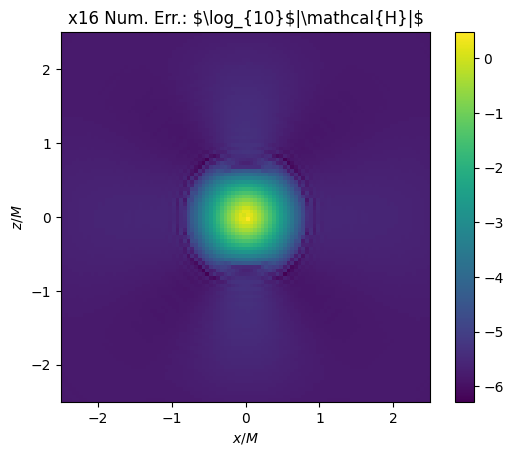

In [17]:
outfile = os.path.join(outdir,'out' + str(Nr) + '.txt')
x,y,valuesCF,valuesHam = np.loadtxt(outfile).T #Transposed for easier unpacking

pl_xmin = -2.5
pl_xmax = +2.5
pl_ymin = -2.5
pl_ymax = +2.5

grid_x, grid_y = np.mgrid[pl_xmin:pl_xmax:100j, pl_ymin:pl_ymax:100j]
points = np.zeros((len(x), 2))
for i in range(len(x)):
    points[i][0] = x[i]
    points[i][1] = y[i]

grid = griddata(points, valuesCF, (grid_x, grid_y), method='nearest')
gridcub = griddata(points, valuesCF, (grid_x, grid_y), method='cubic')

grid = griddata(points, valuesHam, (grid_x, grid_y), method='nearest')
gridcub = griddata(points, valuesHam, (grid_x, grid_y), method='cubic')

# fig, ax = plt.subplots()

plt.clf()
plt.title(r"x16 Num. Err.: $\log_{10}$|\mathcal{H}|$")
plt.xlabel(r"$x/M$")
plt.ylabel(r"$z/M$")

figcub = plt.imshow(gridcub.T, extent=(pl_xmin,pl_xmax, pl_ymin,pl_ymax))
cb = plt.colorbar(figcub)

<a id='compare'></a>

# Step 9: Compare ringdown gravitational wave signal with black hole perturbation theory  \[Back to [top](#toc)\]
$$\label{compare}$$

According to black hole perturbation theory ([Berti et al](https://arxiv.org/abs/0905.2975)), the resultant black hole should ring down with dominant, spin-weight $s=-2$ spherical harmonic mode $(l=2,m=0)$ according to

$$
{}_{s=-2}\text{Re}(\psi_4)_{l=2,m=0} = A e^{−0.0890 t/M} \cos(0.3737 t/M+ \phi),
$$

where $M=1$ for these data, and $A$ and $\phi$ are an arbitrary amplitude and phase, respectively. Here we will plot the resulting waveform at $r/M=33.13$, comparing to the expected frequency and amplitude falloff predicted by black hole perturbation theory.

Notice that we find about 4.2 orders of magnitude agreement! If you are willing to invest more resources and wait much longer, you will find approximately 8.5 orders of magnitude agreement (*better* than Fig 6 of [Ruchlin et al](https://arxiv.org/pdf/1712.07658.pdf)) if you simply set `EvolOption="high resolution"`.

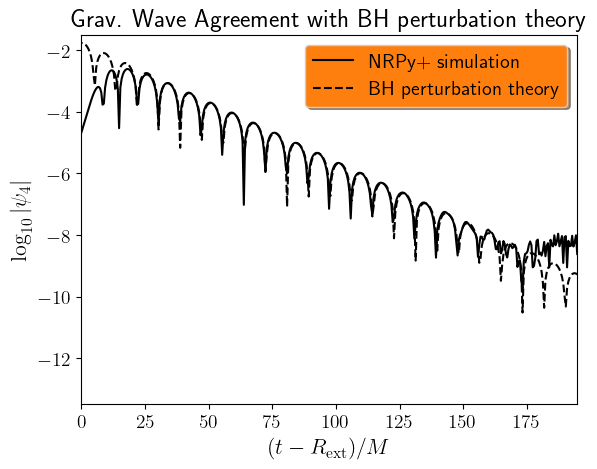

<Figure size 640x480 with 0 Axes>

In [20]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig

from matplotlib import rc
rc('text', usetex=True)


if EvolOption == "low resolution":
    extraction_radius = "30.20"
    Amplitude = 1.8e-2
    Phase     = 2.8
elif EvolOption == "high resolution":
    extraction_radius = "33.64"
    Amplitude = 1.8e-2
    Phase     = 2.8
else:
    print("Error: output is not tuned for Nr = "+str(Nr)+" . Plotting disabled.")
    sys.exit(1)

# Transposed for easier unpacking:
t,psi4r,psi4i = np.loadtxt(os.path.join(outdir, "outpsi4_l2_m0-r"+extraction_radius+".txt")).T

t_retarded    = []
log10abspsi4r = []
bh_pert_thry  = []
for i in range(len(psi4r)):
    retarded_time = t[i]-float(extraction_radius)
    t_retarded.append(retarded_time)
    log10abspsi4r.append(np.log(float(extraction_radius)*np.abs(psi4r[i]))/np.log(10))
    bh_pert_thry.append(np.log(Amplitude*np.exp(-0.0890*retarded_time)*np.abs(np.cos(0.3737*retarded_time+Phase)))/np.log(10))

fig, ax = plt.subplots()
plt.title("Grav. Wave Agreement with BH perturbation theory", fontsize=18)
plt.xlabel(r"$(t - R_{\rm ext})/M$", fontsize=16)
plt.ylabel(r"$\log_{10}|\psi_4|$", fontsize=16)

ax.plot(t_retarded, log10abspsi4r, 'k-', label='NRPy+ simulation')
ax.plot(t_retarded, bh_pert_thry, 'k--', label='BH perturbation theory')
#ax.set_xlim([0,t_retarded[len(psi4r1)-1]])
ax.set_xlim([0, 1.5*domain_size - float(extraction_radius)])
ax.set_ylim([-13.5, -1.5])

plt.xticks(size = 14)
plt.yticks(size = 14)

legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
legend.get_frame().set_facecolor('C1')

plt.show()

# Note that you'll need `dvipng` installed to generate the following file:
savefig(os.path.join(outdir, "BHperttheorycompare.png"), dpi=150)

<a id='latex_pdf_output'></a>

# Step 10: Output this notebook to $\LaTeX$-formatted PDF file \[Back to [top](#toc)\]
$$\label{latex_pdf_output}$$

The following code cell converts this Jupyter notebook into a proper, clickable $\LaTeX$-formatted PDF file. After the cell is successfully run, the generated PDF may be found in the root NRPy+ tutorial directory, with filename
[Tutorial-Start_to_Finish-BSSNCurvilinear-Two_BHs_Collide-Psi4.pdf](Tutorial-Start_to_Finish-BSSNCurvilinear-Two_BHs_Collide-Psi4.pdf) (Note that clicking on this link may not work; you may need to open the PDF file through another means.)

In [19]:
import cmdline_helper as cmd    # NRPy+: Multi-platform Python command-line interface
cmd.output_Jupyter_notebook_to_LaTeXed_PDF("Tutorial-Start_to_Finish-BSSNCurvilinear-Two_BHs_Collide-Psi4")

Created Tutorial-Start_to_Finish-BSSNCurvilinear-Two_BHs_Collide-Psi4.tex,
    and compiled LaTeX file to PDF file Tutorial-Start_to_Finish-
    BSSNCurvilinear-Two_BHs_Collide-Psi4.pdf
